In [1]:
from src.epl_proyection.etl import read_clean_geih
from src.epl_proyection.utils import calendar_features
from src.epl_proyection.etl import read_informal_geih
from src.epl_proyection.etl import preprocessing
from src.epl_proyection.utils import ts_diagnostics
from src.epl_proyection.models.arimax import arimax_forecast
from src.epl_proyection.models.arimax import arimax_train_validate_forecast

In [2]:
df_labor = preprocessing.run_preprocessing_pipeline(path_df2='data/anex-GEIHEISS-nov2024-ene2025.xlsx',
                                                    sheet_name_df2='Grandes dominios ',
                                                    sector=['Agricultura, ganadería, caza, silvicultura y pesca','Industrias manufactureras'],
                                                    cols_to_lag=['Población en edad de trabajar (PET)', 'Población ocupada',
                                                                'Agricultura, ganadería, caza, silvicultura y pesca',
                                                                'Industrias manufactureras', 'Formal', 'Informal'])

In [3]:
import pandas as pd
from src.epl_proyection.models.arimax.arimax_grid_search import grid_search_arimax
from src.epl_proyection.models.arimax.arimax_forecast import train_validate_arimax
fechas_pea = {
    'train_end': "2023-12-01",
    'val_start': "2024-01-01",
    'val_end': "2025-01-01",
    'future_start': "2025-02-01",
    'future_end': "2040-12-01"
}

exog_columns_base = ['workdays', 'weekends', 'holidays', 'negative_crashes']

best_order = grid_search_arimax(df_labor, target_column=['log_población en edad de trabajar (pet)'],
                    exog_columns=exog_columns_base,
                    train_end = fechas_pea['train_end'],
                    val_start = fechas_pea['val_start'],
                    val_end = fechas_pea['val_end'],
                    p_range = (1,3),
                    q_range = (1,3),
                    seasonal_order = (0,1,1,12))

In [4]:
from src.epl_proyection.models.arimax.arimax_forecast import train_validate_arimax
exog_columns_base = ['workdays', 'weekends', 'holidays', 'negative_crashes']
result = train_validate_arimax(
    df = df_labor,
    target_column = 'log_población en edad de trabajar (pet)',
    exog_columns = exog_columns_base,
    train_start = '2001-01-01',
    train_end = "2024-01-01",
    val_start = '2024-02-01',
    val_end = "2040-12-01",
    order=best_order,
    seasonal_order=(0,1,1,12)
)

In [5]:
import numpy as np
df_labor_new = df_labor.merge(result['forecast'].to_frame(), left_index=True, right_index = True , how='left')
df_labor_new.rename(columns = {'predicted_mean':'pred_log_pea'}, inplace= True)
df_labor_new['PredPea'] = np.exp(df_labor_new['pred_log_pea'])

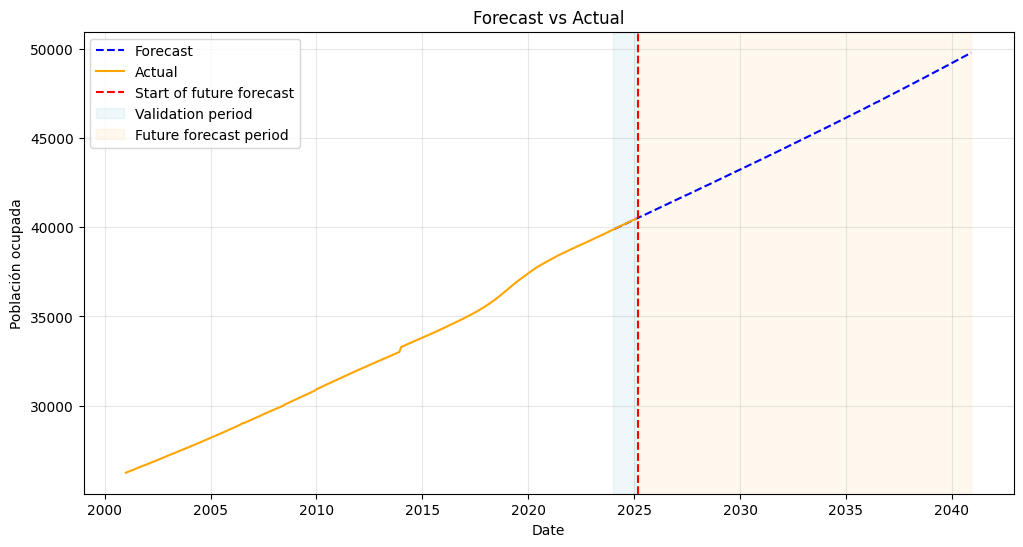

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(df_labor_new['ds'], df_labor_new['PredPea'], label='Forecast', color='blue', linestyle='--')
plt.plot(df_labor_new['ds'], df_labor_new['Población en edad de trabajar (PET)'], label='Actual', color='orange')
plt.axvline(x=pd.to_datetime("2025-03-01"), color='red', linestyle='--', label='Start of future forecast')
plt.axvspan('2024-01-01', '2025-02-01', color='lightblue', alpha=0.2, label='Validation period')
plt.axvspan('2025-03-01', '2040-12-01', color='navajowhite', alpha=0.2, label='Future forecast period')
plt.title('Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Población ocupada')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Forecast con ARIMAX

🔎 Diagnóstico de la serie original:
ADF Statistic: -4.7571
p-value: 0.0001
✅ La serie es estacionaria.


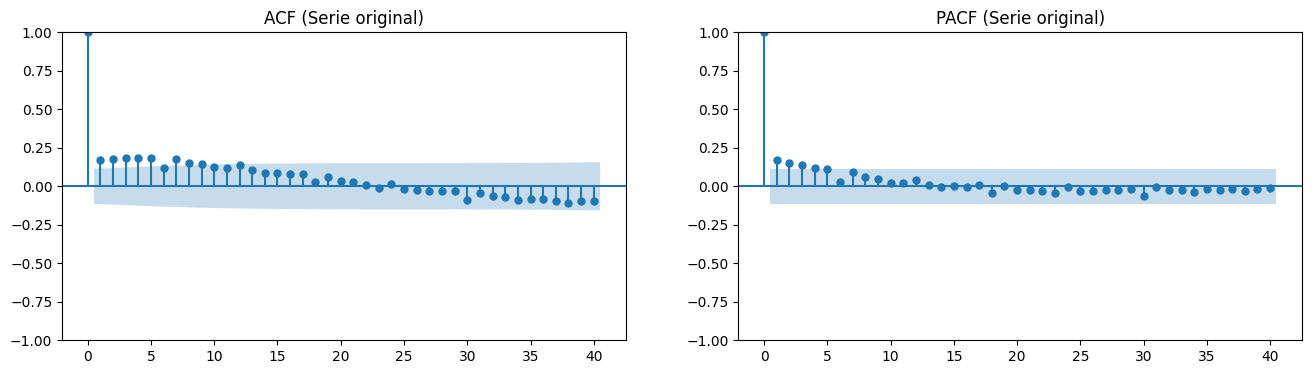

In [15]:
ts_diagnostics.full_ts_diagnostics(df_labor['logdiff_población en edad de trabajar (pet)'])

# Entrenando Catboost

🔎 Diagnóstico de la serie original:
ADF Statistic: -5.3081
p-value: 0.0000
✅ La serie es estacionaria.


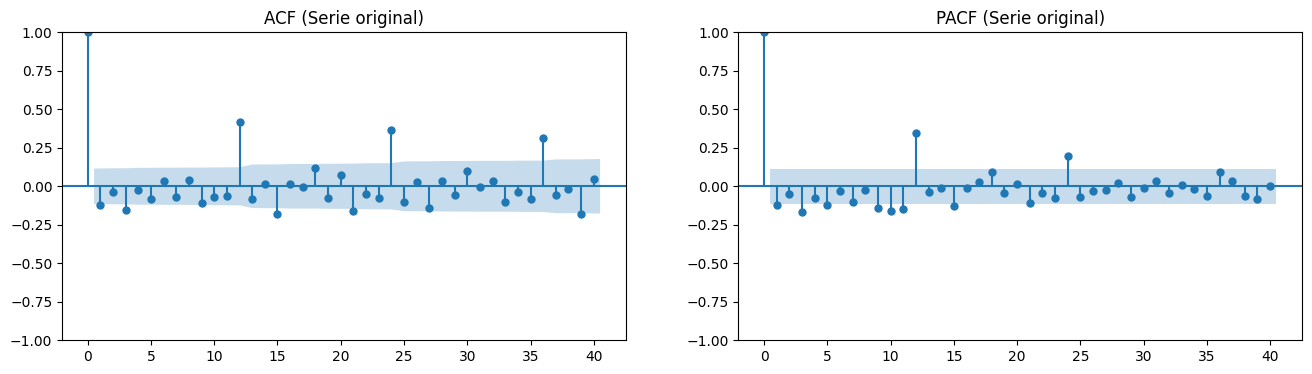

In [4]:
from src.epl_proyection.utils import ts_diagnostics
ts_diagnostics.full_ts_diagnostics(df_labor['logdiff_población ocupada'])

In [8]:
from src.epl_proyection.models.catboost.catboost_main_pipeline import run_catboost_pipeline

# Correr todo el pipeline
df_final = run_catboost_pipeline(df_labor_new, n_trials = 30)

[I 2025-04-28 19:46:37,743] A new study created in memory with name: no-name-69f9efcd-7466-421b-89cf-e065560ca517


[I 2025-04-28 19:46:46,569] Trial 0 finished with value: 0.1801215701281203 and parameters: {'iterations': 710, 'learning_rate': 0.11132448022665231, 'depth': 10, 'l2_leaf_reg': 7.772123936761348, 'bagging_temperature': 0.5120241570785864, 'random_strength': 0.24547348060437524}. Best is trial 0 with value: 0.1801215701281203.
[I 2025-04-28 19:46:48,097] Trial 1 finished with value: 0.02841218984478202 and parameters: {'iterations': 541, 'learning_rate': 0.013931732978854474, 'depth': 7, 'l2_leaf_reg': 0.6243724541795721, 'bagging_temperature': 0.4378069218533972, 'random_strength': 0.33508784196300023}. Best is trial 1 with value: 0.02841218984478202.
[I 2025-04-28 19:46:51,991] Trial 2 finished with value: 0.13692199015748904 and parameters: {'iterations': 971, 'learning_rate': 0.14688616614594996, 'depth': 8, 'l2_leaf_reg': 0.10352490456948613, 'bagging_temperature': 0.2143056899610537, 'random_strength': 0.9291935897524259}. Best is trial 1 with value: 0.02841218984478202.
[I 2025-

0:	learn: 0.0004864	total: 775us	remaining: 542ms
1:	learn: 0.0004800	total: 1.7ms	remaining: 592ms
2:	learn: 0.0004750	total: 2.22ms	remaining: 516ms
3:	learn: 0.0004616	total: 2.84ms	remaining: 494ms
4:	learn: 0.0004484	total: 3.38ms	remaining: 469ms
5:	learn: 0.0004365	total: 3.87ms	remaining: 447ms
6:	learn: 0.0004312	total: 4.53ms	remaining: 449ms
7:	learn: 0.0004278	total: 5.34ms	remaining: 462ms
8:	learn: 0.0004163	total: 5.8ms	remaining: 445ms
9:	learn: 0.0004119	total: 6.63ms	remaining: 457ms
10:	learn: 0.0004009	total: 7.89ms	remaining: 494ms
11:	learn: 0.0003970	total: 8.53ms	remaining: 489ms
12:	learn: 0.0003867	total: 9.26ms	remaining: 489ms
13:	learn: 0.0003762	total: 10.3ms	remaining: 503ms
14:	learn: 0.0003736	total: 10.9ms	remaining: 498ms
15:	learn: 0.0003720	total: 11.7ms	remaining: 500ms
16:	learn: 0.0003626	total: 12.2ms	remaining: 492ms
17:	learn: 0.0003533	total: 13.1ms	remaining: 498ms
18:	learn: 0.0003445	total: 13.8ms	remaining: 496ms
19:	learn: 0.0003358	tota

In [ ]:
df_final.dropna(subset=['pred_logdiff_población en edad de trabajar (pet)'], inplace=True)
df_final = df_final[['ds', 'pred_logdiff_población en edad de trabajar (pet)']].copy()

In [ ]:
df_labor_new = df_labor_new.merge(df_final, left_on='ds', right_on='ds', how='left')

In [15]:
for index,row in df_labor_new.iterrows():
    df_labor_new.at[index, 'pred_log_población en edad de trabajar (pet)'] = df_labor_new.at[index, 'log_población en edad de trabajar (pet)']
    if index == 0:
        continue
    else:
        df_labor_new.at[index, 'pred_log_población en edad de trabajar (pet)'] = df_labor_new.at[index-1, 'pred_log_población en edad de trabajar (pet)'] + row['pred_logdiff_población en edad de trabajar (pet)']
        df_labor_new.at[index, 'pred_pea_catboost'] = np.exp(df_labor_new.at[index, 'pred_log_población en edad de trabajar (pet)'] )